# Hyperspectral Data Analysis with Convolutional Autoencoders

This notebook demonstrates how to use the hyperspectral convolutional autoencoder modules to:
1. Load and preprocess hyperspectral data
2. Handle variable emission band lengths and masked (NaN) values
3. Train and evaluate a convolutional autoencoder with sigmoid activations
4. Visualize results with various methods

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from pathlib import Path

# Import our custom modules
from hyperspectral_dataset import HyperspectralDataset, load_hyperspectral_data
from hyperspectral_models import HyperspectralCAEVariable
from hyperspectral_training import train_variable_cae, evaluate_model
from hyperspectral_visualization import (
    visualize_training_loss,
    visualize_emission_spectrum,
    visualize_multiple_spectra,
    visualize_spatial_slice,
    visualize_feature_maps,
    visualize_reconstruction_comparison,
    visualize_multiple_excitations,
    visualize_all_spectral_bands
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Hyperspectral Data

First, we load the data from a pickle file created by the HyperspectralDataLoader.

In [2]:
# Set the path to your data file
data_path = "../Data/Kiwi Experiment/pickles/masked_KiwiData.pkl"

# Load the data
data_dict = load_hyperspectral_data(data_path)

Loading data from ../Data/Kiwi Experiment/pickles/masked_KiwiData.pkl...
Data Summary:
Number of excitation wavelengths: 21
Excitation wavelengths: [300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0]
Data shape for first excitation (300.0 nm): (1024, 1392, 26)


## 2. Create Dataset with Global Normalization and NaN Handling

Create a dataset that will handle NaN values and apply global normalization to the [0,1] range.

In [3]:
# Create dataset
dataset = HyperspectralDataset(
    data_dict,
    normalize=True,  # Apply global normalization to [0,1]
    downscale_factor=1  # Use full resolution (adjust based on memory constraints)
)

# Get all processed data
all_data = dataset.get_all_data()
spatial_height, spatial_width = dataset.get_spatial_dimensions()

print(f"Processed data dimensions: {spatial_height}x{spatial_width}")

# Print normalization parameters if available
if hasattr(dataset, 'normalization_params'):
    print(f"Global normalization range: [{dataset.normalization_params['min']:.4f}, {dataset.normalization_params['max']:.4f}]")

Preparing data for 21 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 300.0 nm: 26 bands
  - Excitation 310.0 nm: 26 bands
  - Excitation 320.0 nm: 26 bands
  - Excitation 330.0 nm: 26 bands
  - Excitation 340.0 nm: 26 bands
  - Excitation 350.0 nm: 26 bands
  - Excitation 360.0 nm: 28 bands
  - Excitation 370.0 nm: 30 bands
  - Excitation 380.0 nm: 31 bands
  - Excitation 390.0 nm: 31 bands
  - Excitation 400.0 nm: 31 bands
  - Excitation 410.0 nm: 30 bands
  - Excitation 420.0 nm: 29 bands
  - Excitation 430.0 nm: 28 bands
  - Excitation 440.0 nm: 27 bands
  - Excitation 450.0 nm: 26 bands
  - Excitation 460.0 nm: 25 bands
  - Excitation 470.0 nm: 24 bands
  - Excitation 480.0 nm: 23 bands
  - Excitation 490.0 nm: 22 bands
  - Excitation 500.0 nm: 21 bands
Total NaN values replaced: 138050804 (14.6999% of entire dataset)
Global data range: [0.0000, 4027.0000]
Data normalized to range [0, 1] using global normalization
Data preparation com

## 3. Create and Train the Convolutional Autoencoder Model

Now we'll create our model and train it using chunking for memory efficiency.

In [4]:
# Create model
model = HyperspectralCAEVariable(
    excitations_data={ex: data.numpy() for ex, data in all_data.items()},
    k1=20,  # Number of filters in first layer
    k3=20,  # Number of filters in third layer
    filter_size=5,
    sparsity_target=0.1,  # Lower value for sigmoid activation
    sparsity_weight=1.0,
    dropout_rate=0.5,
    debug=False
)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 354522 parameters


C:\Users\meloy\PycharmProjects\Capstone\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Creating spatial chunks for each excitation wavelength...
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created 2494 chunks of size up to 32x32 with 8 overlap
Created

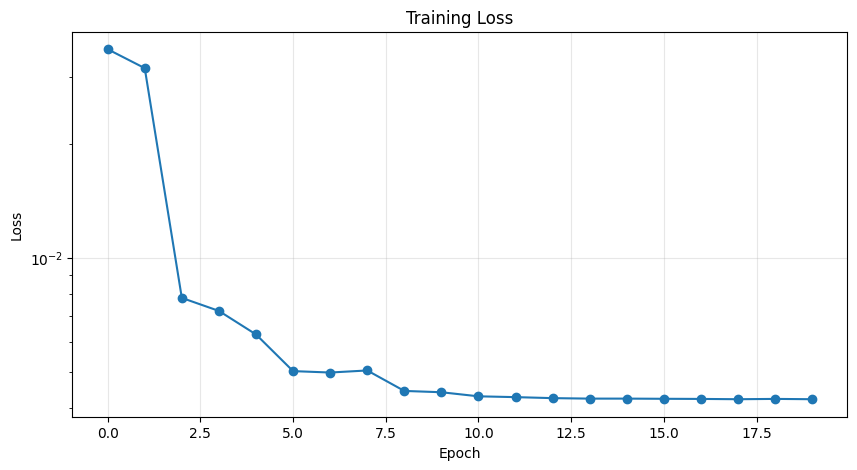

In [5]:
# Train model (or load a previously trained model)
train_new_model = True  # Set to False to load a previously saved model

if train_new_model:
    model, losses = train_variable_cae(
        model,
        dataset,
        num_epochs=20,
        learning_rate=0.01,
        chunk_size=32,
        chunk_overlap=8,
        early_stopping_patience=5  # Stop if no improvement for 5 epochs
    )
    
    # Save the final model (best model is saved during training)
    torch.save(model.state_dict(), "hyperspectral_cae_final_model.pth")
    print("Final model saved to hyperspectral_cae_final_model.pth")
    
    # Visualize training loss
    visualize_training_loss(losses)
else:
    # Load previously trained model
    model_path = "best_hyperspectral_model.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")

## 4. Evaluate the Model

Generate reconstructions and evaluate the model performance.

In [6]:
# Evaluate the model
evaluation_results = evaluate_model(model, dataset, chunk_size=64, chunk_overlap=8, device=device)

# Print overall metrics
if 'overall' in evaluation_results['metrics']:
    print(f"\nOverall Metrics:")
    for metric, value in evaluation_results['metrics']['overall'].items():
        print(f"  {metric.upper()}: {value:.4f}")

Evaluating model on test data...
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 300.0nm - MSE: 0.0000, MAE: 0.0037, PSNR: 46.18 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 310.0nm - MSE: 0.0000, MAE: 0.0045, PSNR: 44.34 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 320.0nm - MSE: 0.0001, MAE: 0.0055, PSNR: 41.89 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 330.0nm - MSE: 0.0001, MAE: 0.0071, PSNR: 38.56 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 340.0nm - MSE: 0.0003, MAE: 0.0093, PSNR: 34.89 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 350.0nm - MSE: 0.0007, MAE: 0.0127, PSNR: 31.51 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 360.0nm - MSE: 0.0009, MAE: 0.0147, PSNR: 30.68 dB
Created 475 chunks of size up to 64x64 with 8 overlap
Excitation 370.0nm - MSE: 0.0010, MAE: 0.0171, PSNR: 30.10 dB
Created 475 chunks of size up to 64x64 

## 5. Generate Reconstructions for Visualization

For visualization purposes, we'll generate reconstructions for all excitations.

In [7]:
# Generate reconstructions for all excitations
model.eval()
reconstructions = {}

for ex, data in all_data.items():
    # Add batch dimension
    data_batch = {ex: data.unsqueeze(0).to(device)}
    
    # Generate reconstruction
    with torch.no_grad():
        output = model(data_batch)
    
    # Store reconstruction
    if ex in output:
        reconstructions[ex] = output[ex][0].cpu()  # Remove batch dimension
        print(f"Generated reconstruction for excitation {ex}nm. "
              f"Shape: {reconstructions[ex].shape}, "
              f"Range: [{reconstructions[ex].min().item():.4f}, {reconstructions[ex].max().item():.4f}]")

Generated reconstruction for excitation 300.0nm. Shape: torch.Size([1024, 1392, 26]), Range: [0.0020, 0.0047]
Generated reconstruction for excitation 310.0nm. Shape: torch.Size([1024, 1392, 26]), Range: [0.0020, 0.0065]
Generated reconstruction for excitation 320.0nm. Shape: torch.Size([1024, 1392, 26]), Range: [0.0022, 0.0096]
Generated reconstruction for excitation 330.0nm. Shape: torch.Size([1024, 1392, 26]), Range: [0.0023, 0.0152]
Generated reconstruction for excitation 340.0nm. Shape: torch.Size([1024, 1392, 26]), Range: [0.0025, 0.0204]
Generated reconstruction for excitation 350.0nm. Shape: torch.Size([1024, 1392, 26]), Range: [0.0027, 0.0339]
Generated reconstruction for excitation 360.0nm. Shape: torch.Size([1024, 1392, 28]), Range: [0.0027, 0.0477]
Generated reconstruction for excitation 370.0nm. Shape: torch.Size([1024, 1392, 30]), Range: [0.0027, 0.0711]
Generated reconstruction for excitation 380.0nm. Shape: torch.Size([1024, 1392, 31]), Range: [0.0026, 0.0952]
Generated 

## 6. Visualizations

Now we'll create various visualizations to analyze the results.

### 6.1 Emission Spectrum Analysis

First, let's visualize the emission spectrum at different spatial locations.

Analyzing excitation wavelength: 300.0nm
Emission wavelength range: 420.0nm - 720.0nm


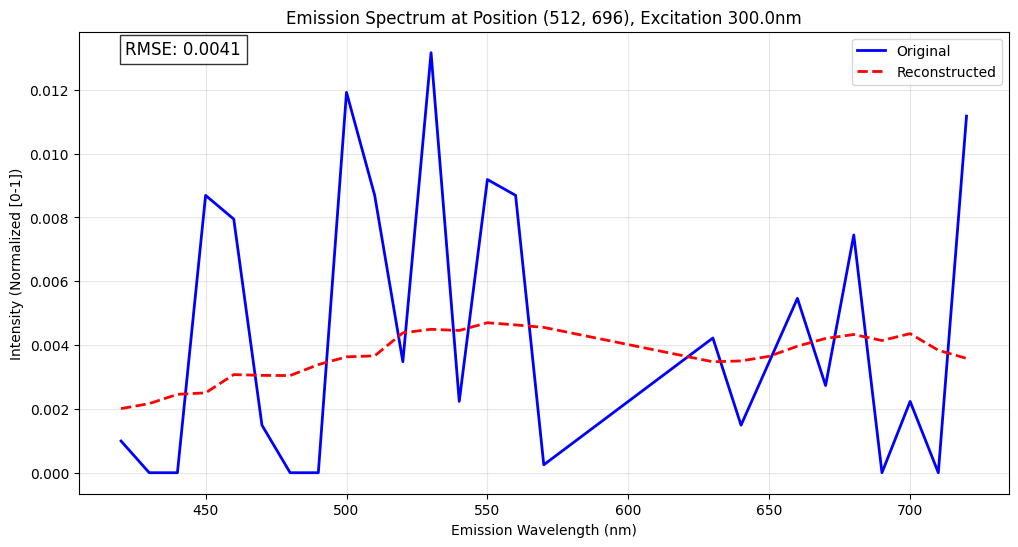

Center pixel RMSE: 0.0041


In [8]:
# Select a specific excitation wavelength to analyze
excitation_to_analyze = list(all_data.keys())[0]  # Use first excitation
print(f"Analyzing excitation wavelength: {excitation_to_analyze}nm")

# Get original and reconstructed data
original_data = all_data[excitation_to_analyze]
reconstructed_data = reconstructions[excitation_to_analyze]

# Get emission wavelengths if available
emission_wavelengths = dataset.emission_wavelengths.get(excitation_to_analyze, None)
if emission_wavelengths:
    print(f"Emission wavelength range: {min(emission_wavelengths)}nm - {max(emission_wavelengths)}nm")

# Visualize spectrum at center pixel
center_y, center_x = spatial_height // 2, spatial_width // 2
rmse = visualize_emission_spectrum(
    original_data,
    reconstructed_data,
    excitation_to_analyze,
    y=center_y,
    x=center_x,
    wavelengths=emission_wavelengths
)
print(f"Center pixel RMSE: {rmse:.4f}")

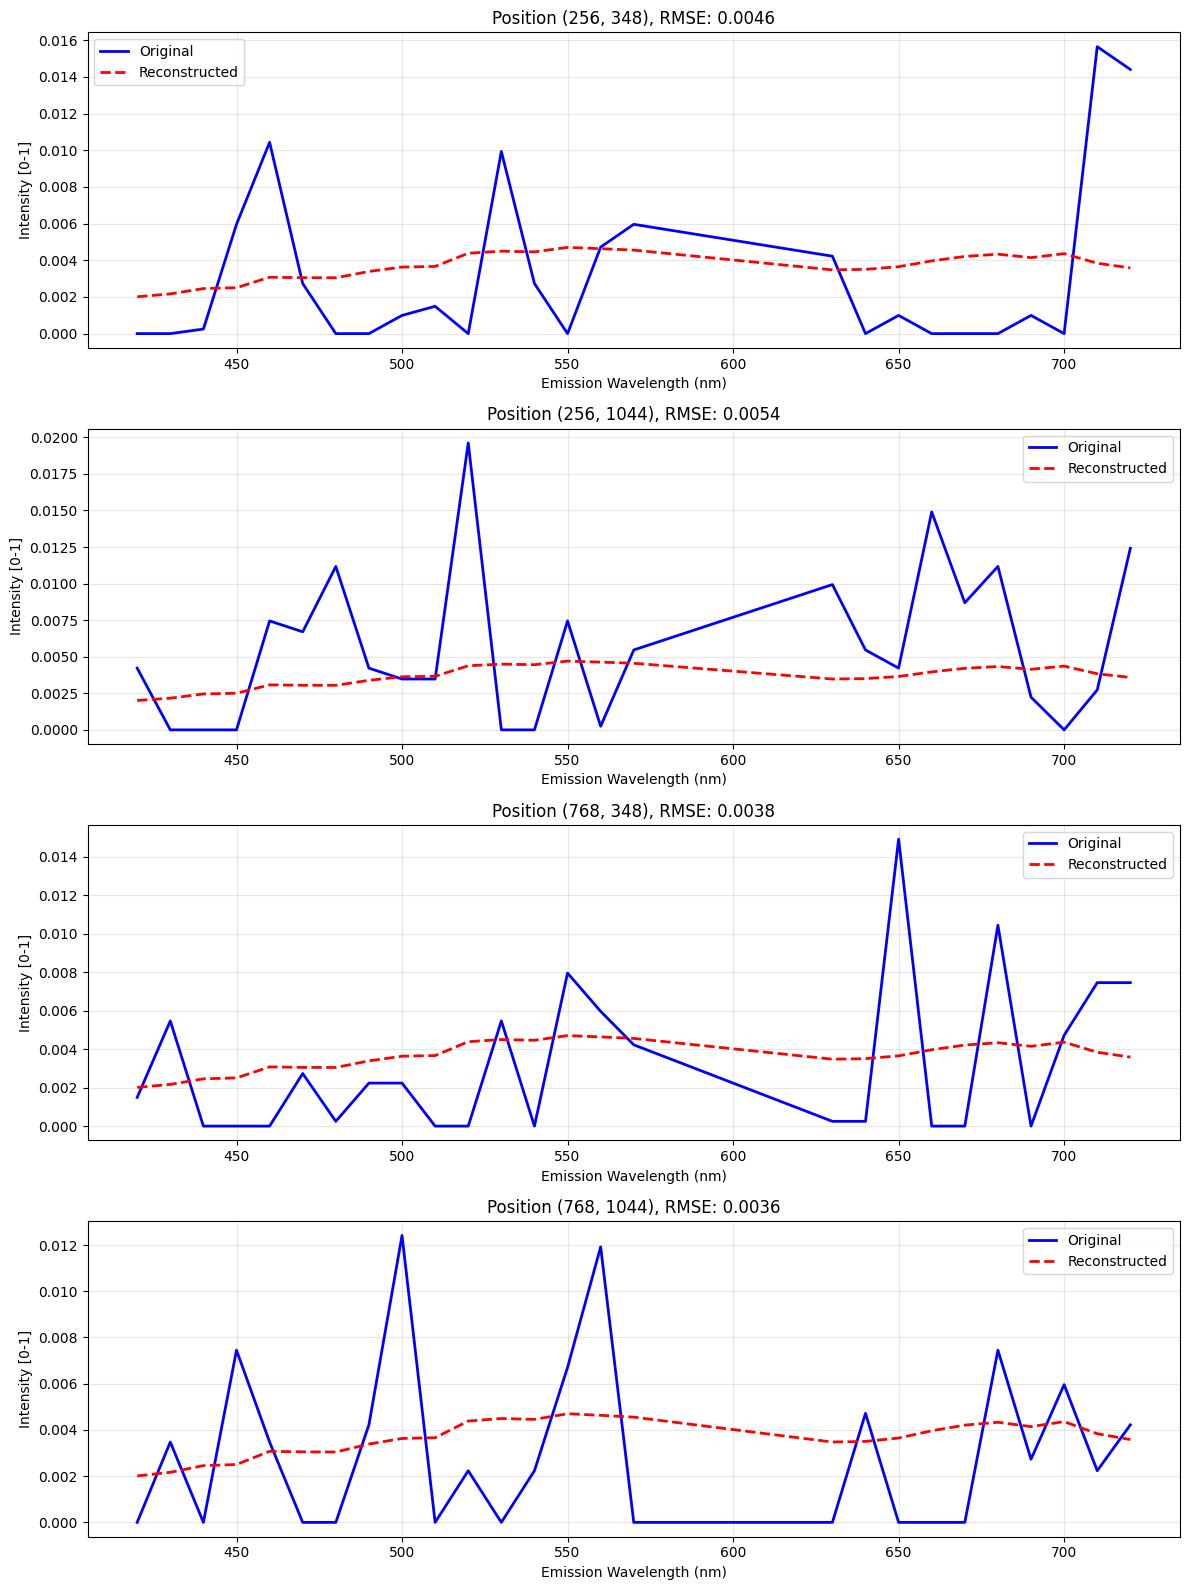

RMSE at different positions: ['0.0046', '0.0054', '0.0038', '0.0036']


In [9]:
# Visualize multiple spectra at different positions
h_quarter, w_quarter = spatial_height // 4, spatial_width // 4
positions = [
    (h_quarter, w_quarter),
    (h_quarter, spatial_width - w_quarter),
    (spatial_height - h_quarter, w_quarter),
    (spatial_height - h_quarter, spatial_width - w_quarter)
]

rmse_values = visualize_multiple_spectra(
    original_data,
    reconstructed_data,
    excitation_to_analyze,
    positions=positions,
    wavelengths=emission_wavelengths
)
print(f"RMSE at different positions: {[f'{rmse:.4f}' for rmse in rmse_values]}")

### 6.2 Spatial Slice Analysis

Now let's look at spatial slices for specific emission bands.

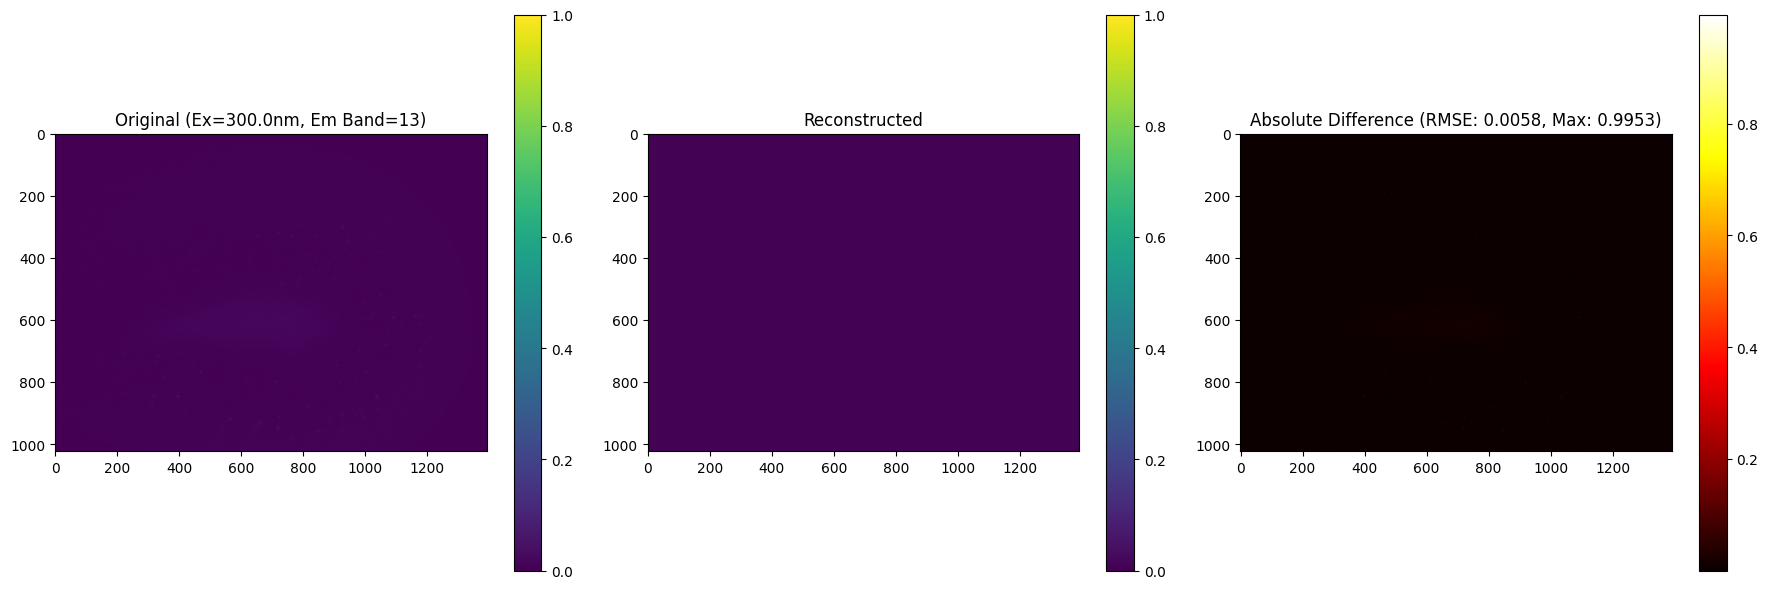

Spatial metrics for emission band 13:
  rmse: 0.0058
  max_diff: 0.9953
  mean_diff: 0.0045


In [10]:
# Visualize a spatial slice for a specific emission band
# Use the middle emission band
middle_band = original_data.shape[2] // 2

metrics = visualize_spatial_slice(
    original_data,
    reconstructed_data,
    excitation_to_analyze,
    emission_idx=middle_band,
    cmap='viridis'
)

print(f"Spatial metrics for emission band {middle_band}:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

### 6.3 Feature Maps Visualization

Let's examine what features the model is learning.

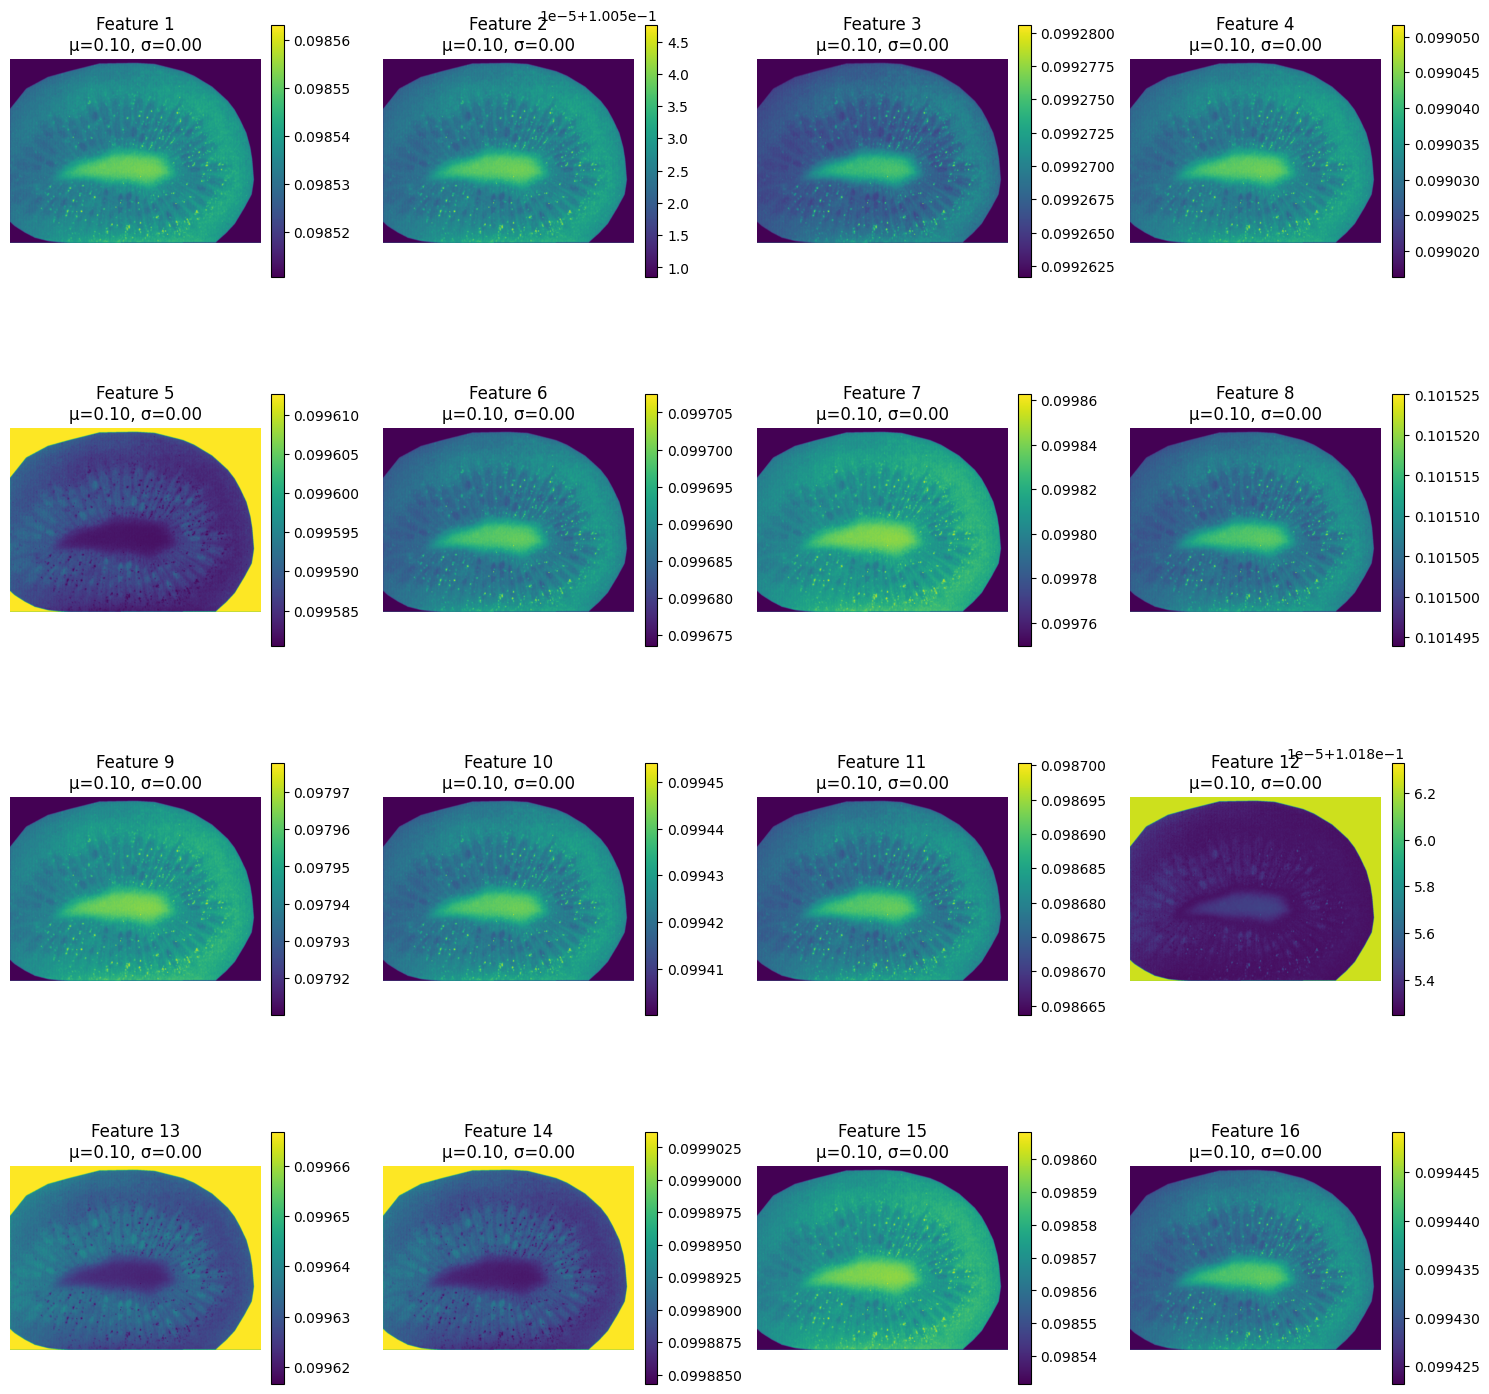


Feature Map Statistics:
  Mean activation range: [0.0979, 0.1036]
  Mean standard deviation: 0.0000


In [11]:
# Visualize feature maps
feature_stats = visualize_feature_maps(
    model,
    {excitation_to_analyze: all_data[excitation_to_analyze]},
    num_maps=16,
    cmap='viridis',
    device=device
)

# Print feature activation statistics
print("\nFeature Map Statistics:")
print(f"  Mean activation range: [{np.min(feature_stats['means']):.4f}, {np.max(feature_stats['means']):.4f}]")
print(f"  Mean standard deviation: {np.mean(feature_stats['stds']):.4f}")

### 6.4 RGB False Color Visualization

Create false color visualizations to compare original and reconstructed data.

Using consistent normalization range: [0.0000, 1.0000]
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm


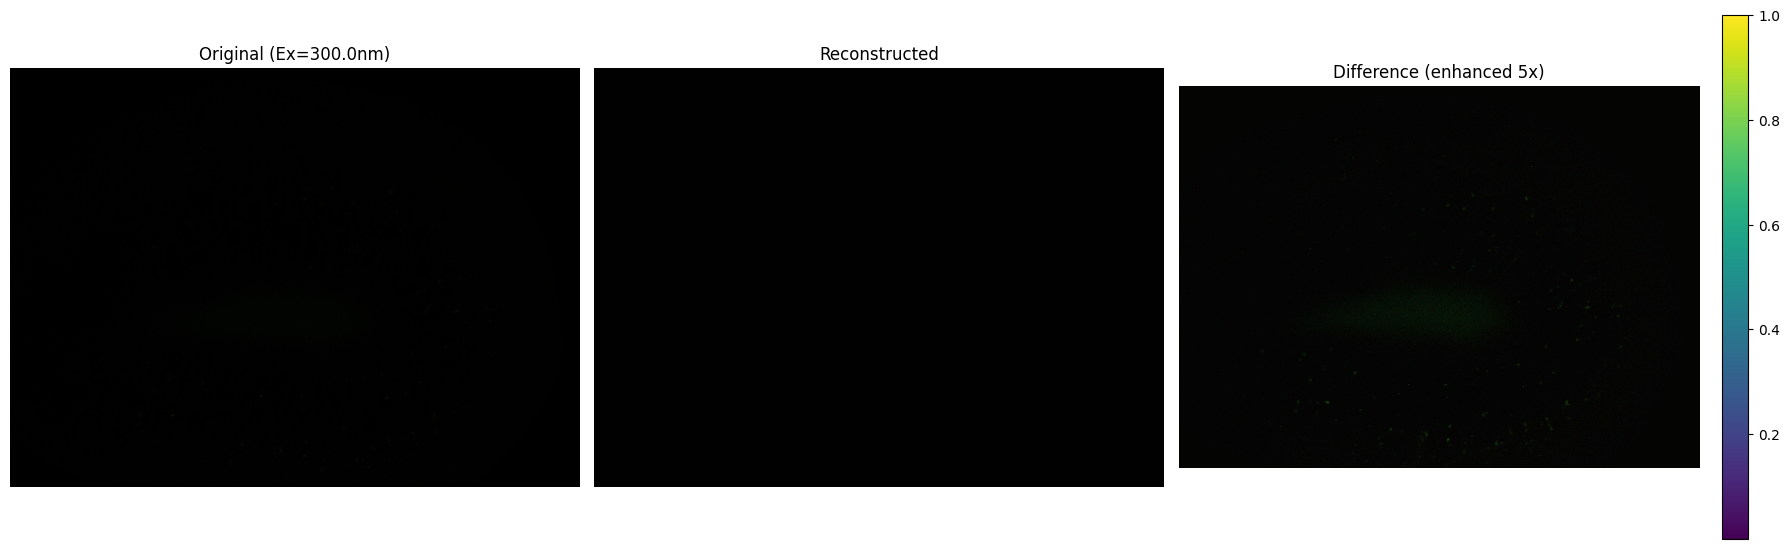

RMSE per channel: R=0.0046, G=0.0058, B=0.0040, Overall=0.0048

RGB Channel RMSE Values:
  R: 0.0046
  G: 0.0058
  B: 0.0040
  OVERALL: 0.0048


In [16]:
# RGB false color visualization for a single excitation
visualization_results = visualize_reconstruction_comparison(
    original_data,
    reconstructed_data,
    emission_wavelengths,
    excitation_to_analyze,
    use_consistent_normalization=True
)

# Print RGB channel RMSE values
print("\nRGB Channel RMSE Values:")
for channel, value in visualization_results['rmse'].items():
    print(f"  {channel.upper()}: {value:.4f}")

Using global normalization range: [0.0000, 1.0000]
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=670.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=670.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=450.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=460.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=460.0nm
Using emission bands: R=650.0nm, G=550.0nm, B=480.0nm
Using emission bands: R=650.0nm

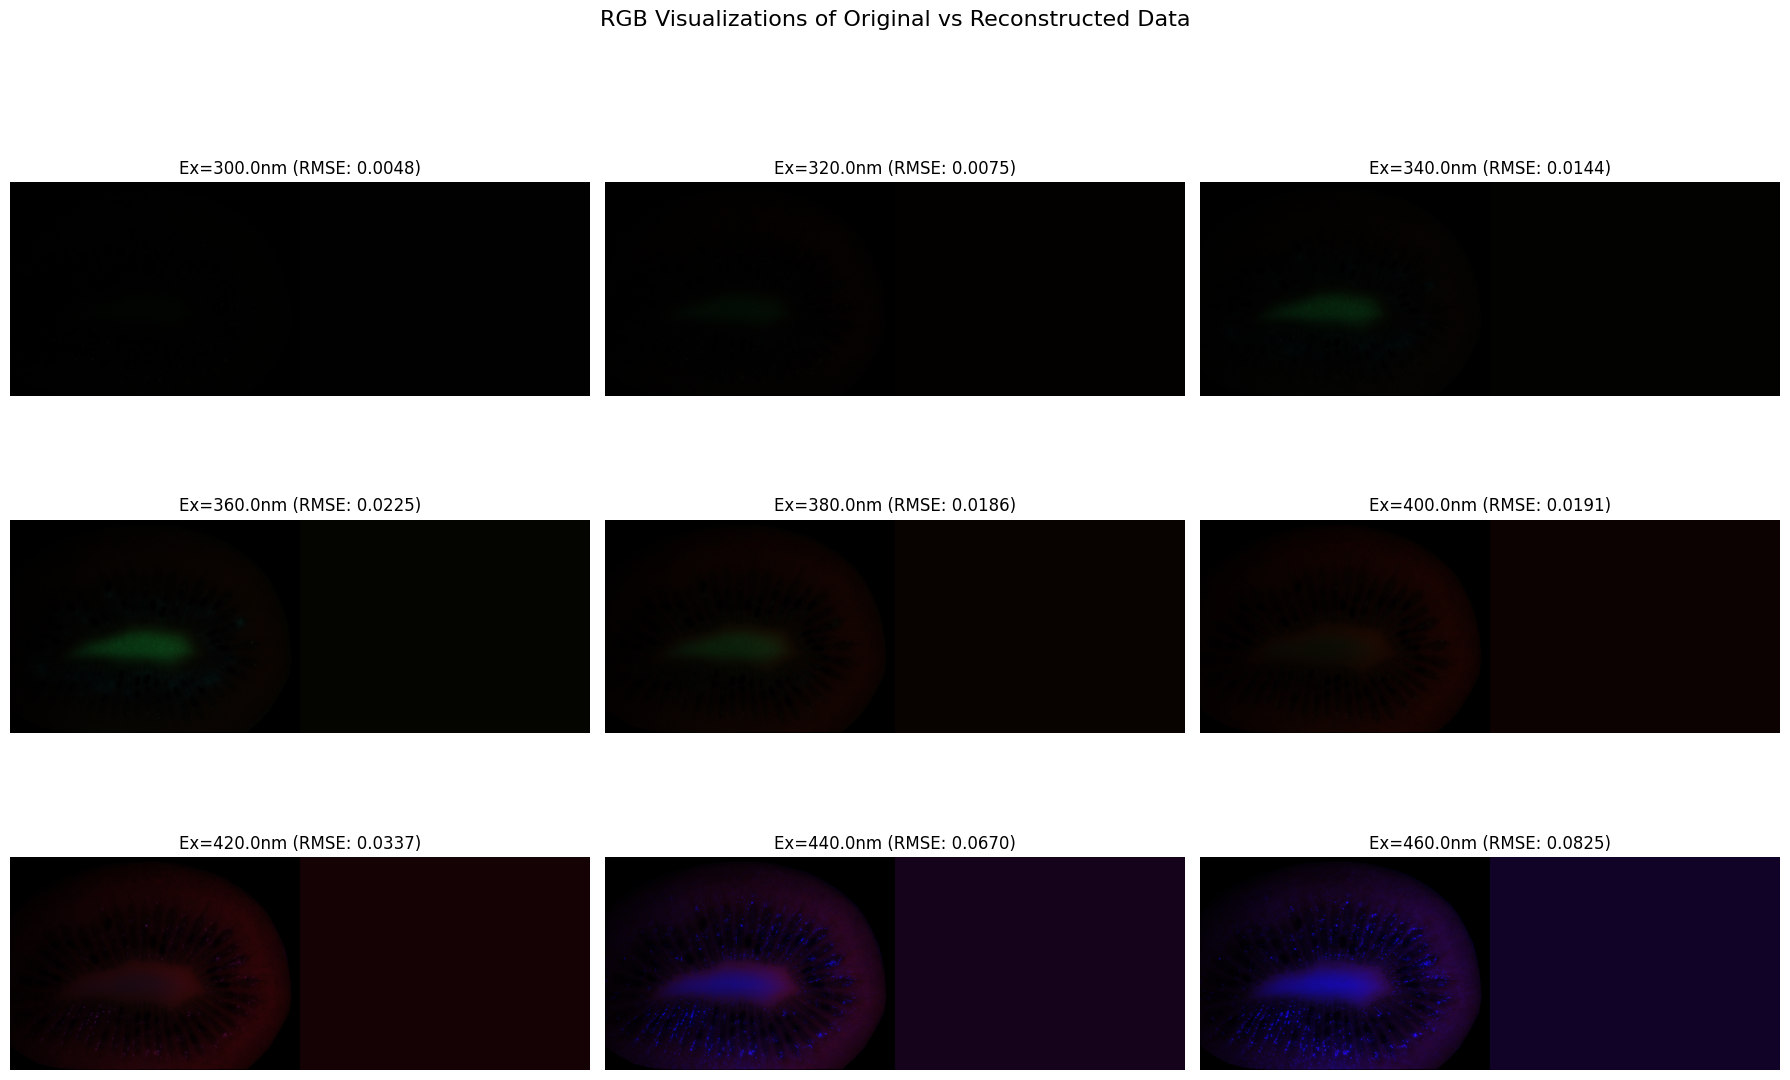


RMSE for each excitation wavelength:
  Ex=300.0nm: 0.0048
  Ex=320.0nm: 0.0075
  Ex=340.0nm: 0.0144
  Ex=360.0nm: 0.0225
  Ex=380.0nm: 0.0186
  Ex=400.0nm: 0.0191
  Ex=420.0nm: 0.0337
  Ex=440.0nm: 0.0670
  Ex=460.0nm: 0.0825


In [17]:
# Visualize multiple excitations
rmse_values = visualize_multiple_excitations(
    model,
    all_data,
    dataset.emission_wavelengths,
    use_consistent_normalization=True,
    device=device
)

# Print RMSE for each excitation
print("\nRMSE for each excitation wavelength:")
for ex, rmse in sorted(rmse_values.items()):
    print(f"  Ex={ex}nm: {rmse:.4f}")

### 6.5 Detailed Spectral Band Analysis

Visualize all spectral bands for a specific excitation.

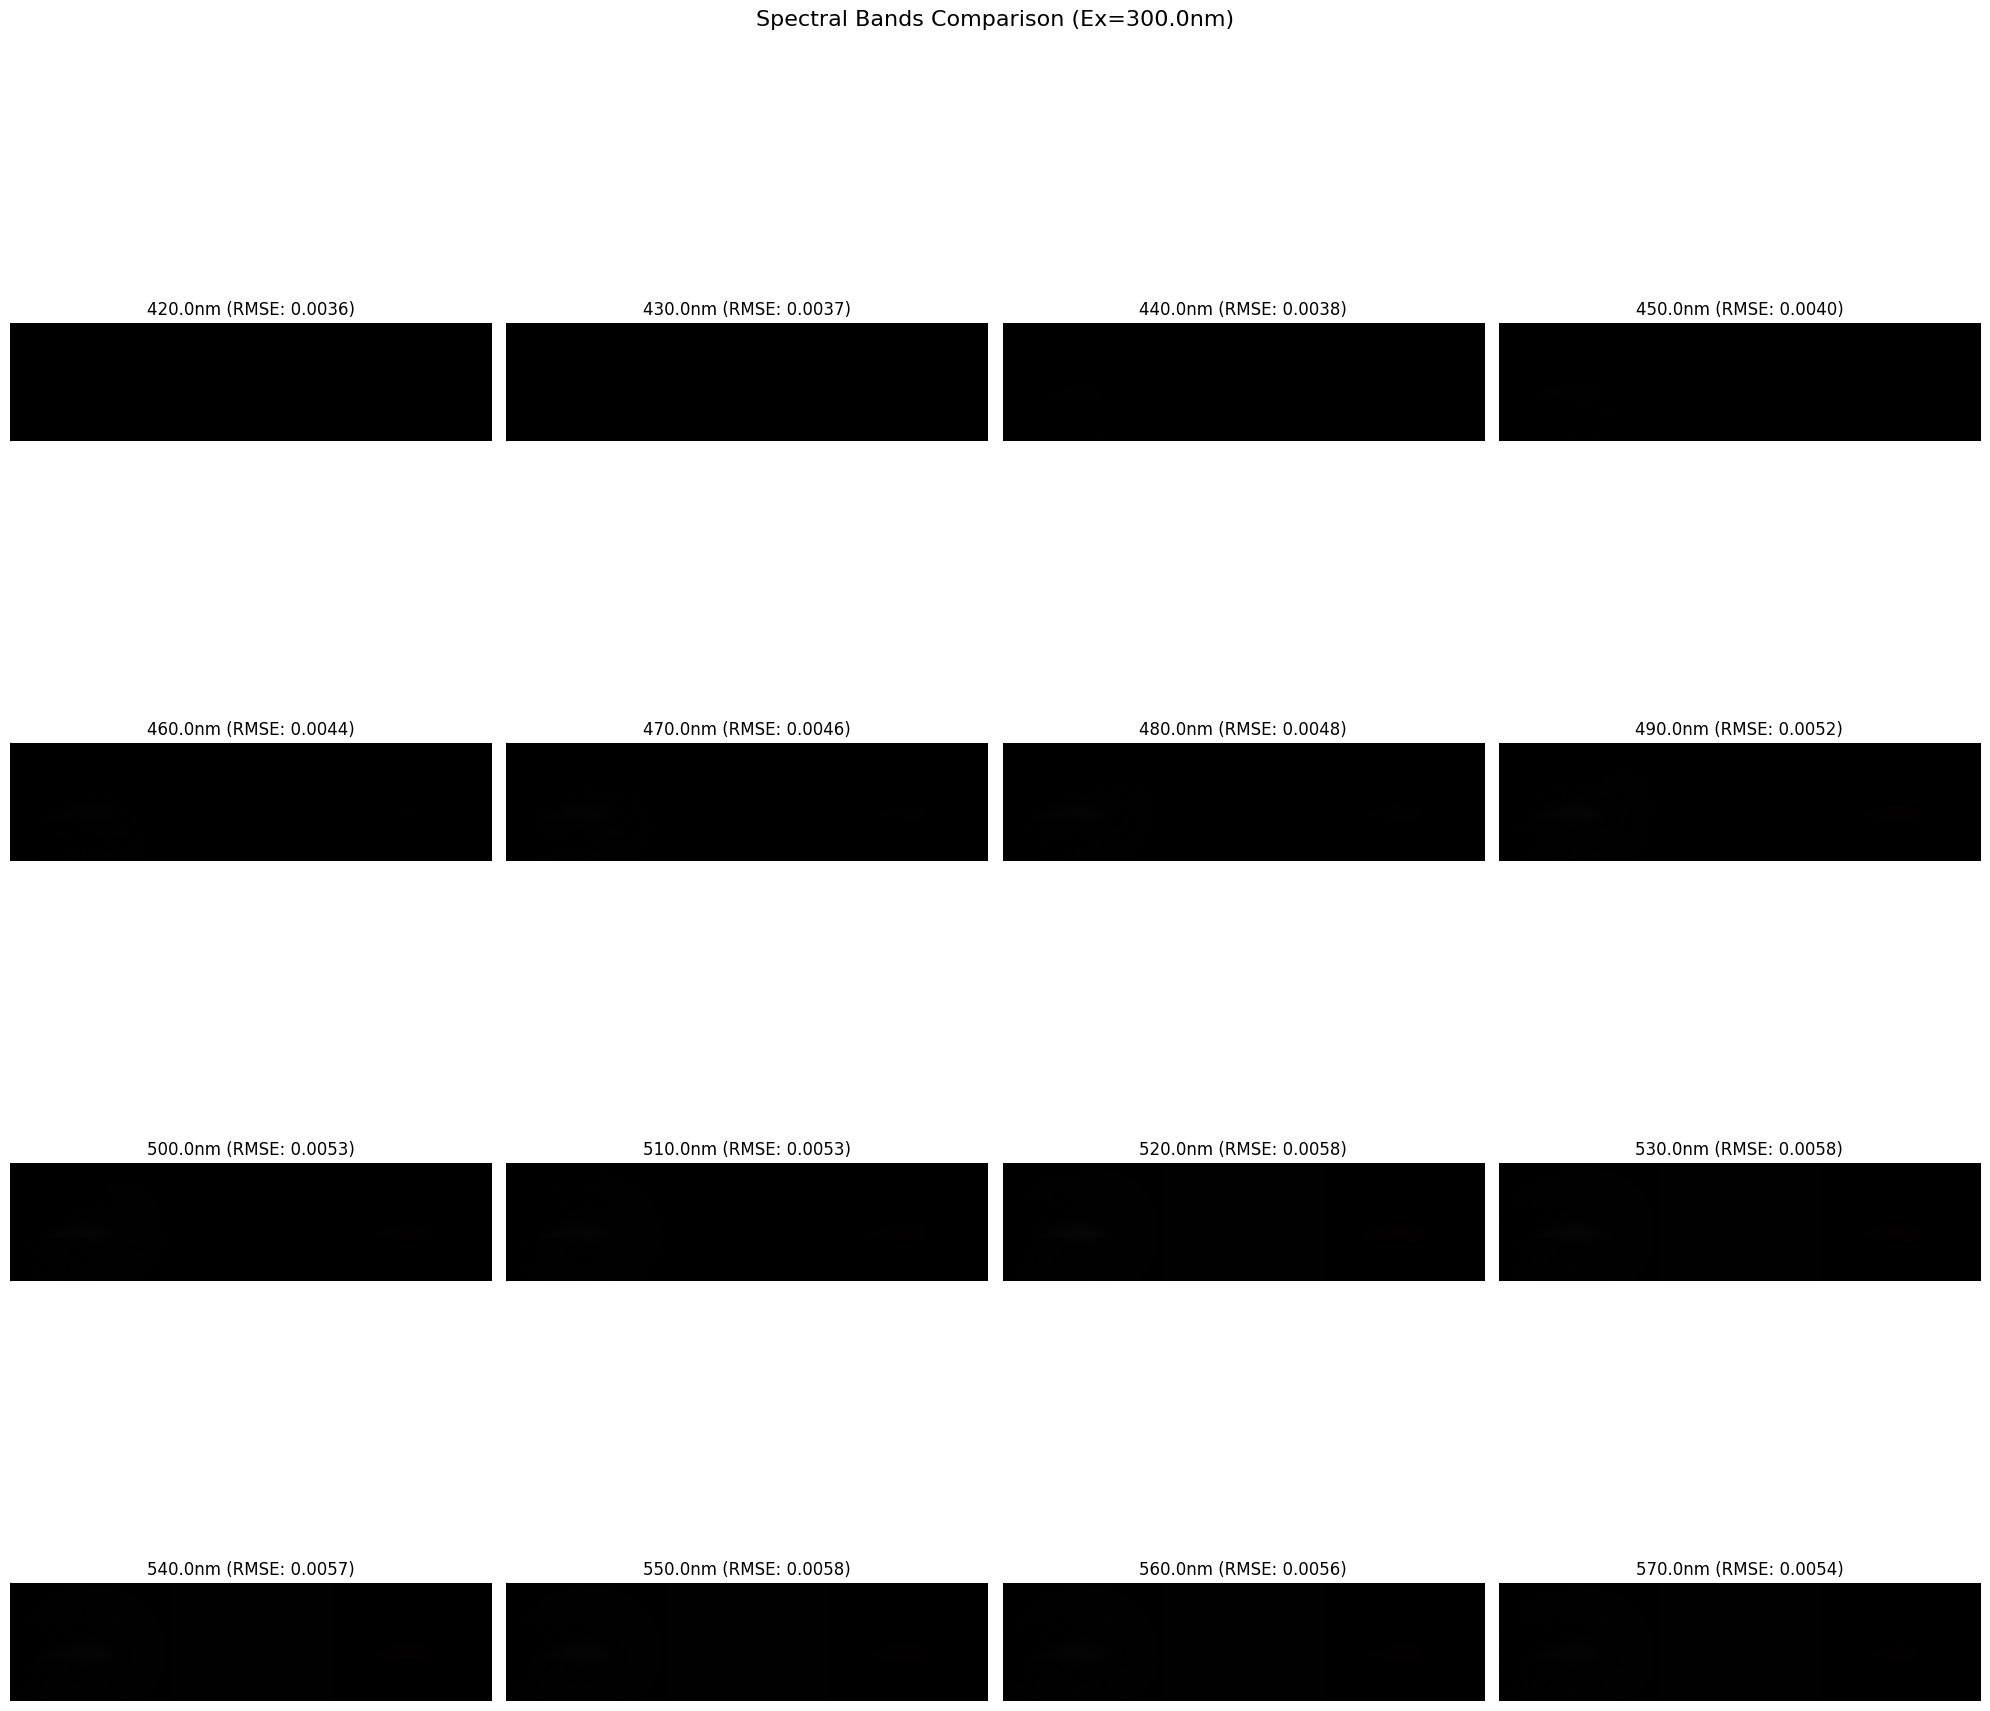


Best reconstructed band: 420.0nm (RMSE: 0.0036)
Worst reconstructed band: 520.0nm (RMSE: 0.0058)


In [18]:
# Visualize all spectral bands
band_rmse = visualize_all_spectral_bands(
    original_data,
    reconstructed_data,
    excitation_to_analyze,
    emission_wavelengths=emission_wavelengths,
    grid_size=4,  # Adjust based on number of bands
    cmap='viridis'
)

# Find best and worst reconstructed bands
best_band = min(band_rmse.items(), key=lambda x: x[1])
worst_band = max(band_rmse.items(), key=lambda x: x[1])

best_wavelength = emission_wavelengths[best_band[0]] if emission_wavelengths else best_band[0]
worst_wavelength = emission_wavelengths[worst_band[0]] if emission_wavelengths else worst_band[0]

print(f"\nBest reconstructed band: {best_wavelength}nm (RMSE: {best_band[1]:.4f})")
print(f"Worst reconstructed band: {worst_wavelength}nm (RMSE: {worst_band[1]:.4f})")

## 7. Analysis Summary

Create a summary of the model performance and visualization results.

In [19]:
# Calculate overall metrics for all excitations
overall_metrics = {}
all_rmse = []

for ex in reconstructions:
    if ex in all_data:
        orig = all_data[ex]
        recon = reconstructions[ex]
        
        # MSE
        mse = torch.mean((orig - recon) ** 2).item()
        rmse = np.sqrt(mse)
        
        # MAE
        mae = torch.mean(torch.abs(orig - recon)).item()
        
        all_rmse.append(rmse)
        
        # Store metrics
        overall_metrics[ex] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae
        }

# Print summary
print("\nModel Performance Summary:")
print(f"Number of excitation wavelengths: {len(reconstructions)}")
print(f"Average RMSE across all excitations: {np.mean(all_rmse):.4f}")
print(f"Best excitation: {min(overall_metrics.items(), key=lambda x: x[1]['rmse'])[0]}")
print(f"Worst excitation: {max(overall_metrics.items(), key=lambda x: x[1]['rmse'])[0]}")


Model Performance Summary:
Number of excitation wavelengths: 21
Average RMSE across all excitations: 0.0488
Best excitation: 300.0
Worst excitation: 500.0
